In [22]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")
import mne

Extracting EDF parameters from D:\VECG\Data\DataAmy\Amy1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4999  =      0.000 ...     9.998 secs...


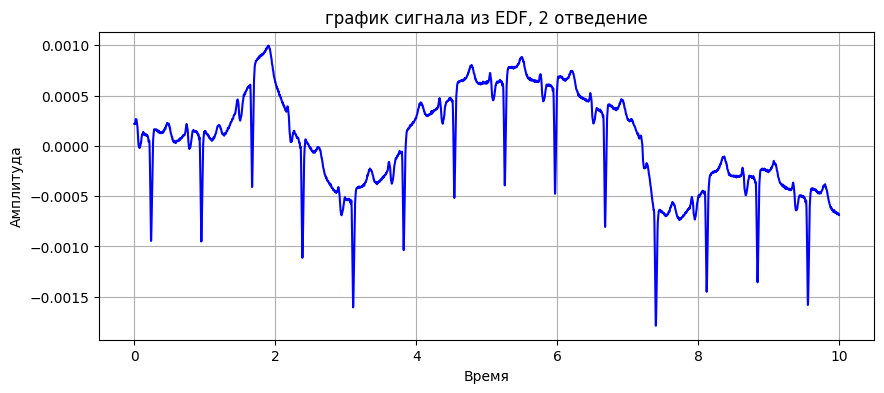

In [38]:
edf_file_path = 'D:/VECG/Data/DataAmy/Amy1.edf'
raw = mne.io.read_raw_edf(edf_file_path, preload=True)
signal = raw.get_data(picks=[3])
signal = signal.flatten() 
times = raw.times

plt.figure(figsize=(10, 4))
plt.plot(times, signal, color='b')
plt.title('график сигнала из EDF, 2 отведение')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.grid()
plt.show()

In [24]:
df = pd.read_csv('D:/VECG/Features/features.csv')

In [25]:
df = df.drop(columns=['File_Name'])

In [26]:
print(f"Пропуски в данных:\n{df.isna().sum()}")
df.fillna(df.median(), inplace=True)

Пропуски в данных:
Male                    0
Female                  0
Age                     0
Class                   0
Square_QRS_frontal      0
Square_QRS_sagittal     0
Square_QRS_axial        0
Square_ST_frontal       0
Square_ST_sagittal      0
Square_ST_axial         0
Frontal_Angle_QRST     11
Eccentricity_QRS        0
Mean_Velocity           0
Max_Velocity            0
QRS_duration            6
dtype: int64


In [27]:
y = df['Class']
X = df.drop(columns=['Class'])

In [28]:
def augment_data_with_noise(X, y, noise_factor=0.01, jitter_factor=0.01):
    augmented_data = []
    augmented_labels = []
    
    for index in range(len(X)):
        signal = X.iloc[index].values
        label = y.iloc[index]

        augmented_data.append(signal)
        augmented_labels.append(label)
        
        noise = np.random.normal(0, noise_factor, size=signal.shape)
        noisy_signal = signal + noise
        augmented_data.append(noisy_signal)
        augmented_labels.append(label)
        
        jitter = np.random.normal(0, jitter_factor, size=signal.shape)
        jittered_signal = signal + jitter
        augmented_data.append(jittered_signal)
        augmented_labels.append(label)

    return np.array(augmented_data), np.array(augmented_labels)

In [29]:
X_augmented, y_augmented = augment_data_with_noise(X, y, noise_factor=0.05, jitter_factor=0.03)
print(f"Количество аугментированных данных: {len(X_augmented)}")

Количество аугментированных данных: 90


In [30]:
scaler = StandardScaler()
X_augmented = scaler.fit_transform(X_augmented)
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.25, stratify=y_augmented, random_state=42)

In [31]:
# Применение SMOTE для увеличения числа данных меньшинств
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Размер обучающей выборки: {X_train_resampled.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер обучающей выборки: 68
Размер тестовой выборки: 23


In [32]:
catboost_model = CatBoostClassifier(depth=5, learning_rate=0.1, iterations=200, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(catboost_model, X_train_resampled, y_train_resampled, cv=kf, scoring='f1_weighted')
print(f"Средний F1 Score на кросс-валидации: {np.mean(cv_scores)}")
catboost_model.fit(X_train_resampled, y_train_resampled, verbose=False)
y_pred = catboost_model.predict(X_test)

0:	learn: 0.6392480	total: 25.6ms	remaining: 5.09s
1:	learn: 0.5868417	total: 31.9ms	remaining: 3.16s
2:	learn: 0.5222249	total: 38.5ms	remaining: 2.53s
3:	learn: 0.4665282	total: 45ms	remaining: 2.21s
4:	learn: 0.4264516	total: 51.9ms	remaining: 2.02s
5:	learn: 0.3940750	total: 72ms	remaining: 2.33s
6:	learn: 0.3650897	total: 80ms	remaining: 2.21s
7:	learn: 0.3277589	total: 83.7ms	remaining: 2.01s
8:	learn: 0.2943286	total: 87.1ms	remaining: 1.85s
9:	learn: 0.2645857	total: 91.3ms	remaining: 1.73s
10:	learn: 0.2455222	total: 98.4ms	remaining: 1.69s
11:	learn: 0.2297053	total: 106ms	remaining: 1.65s
12:	learn: 0.2171198	total: 116ms	remaining: 1.67s
13:	learn: 0.1924394	total: 122ms	remaining: 1.62s
14:	learn: 0.1846955	total: 126ms	remaining: 1.55s
15:	learn: 0.1733591	total: 129ms	remaining: 1.48s
16:	learn: 0.1682116	total: 132ms	remaining: 1.42s
17:	learn: 0.1589278	total: 136ms	remaining: 1.38s
18:	learn: 0.1467086	total: 139ms	remaining: 1.32s
19:	learn: 0.1373770	total: 143ms	re

In [33]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")

Accuracy: 0.8260869565217391
F1 Score: 0.8191856452726018
Recall: 0.8260869565217391


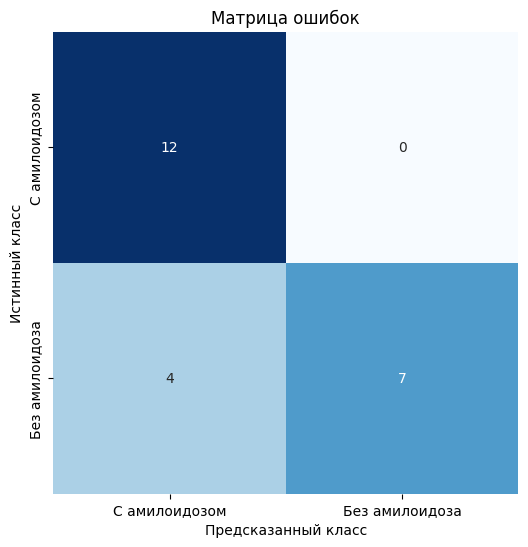

In [34]:

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['С амилоидозом', 'Без амилоидоза'],
            yticklabels=['С амилоидозом', 'Без амилоидоза'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()


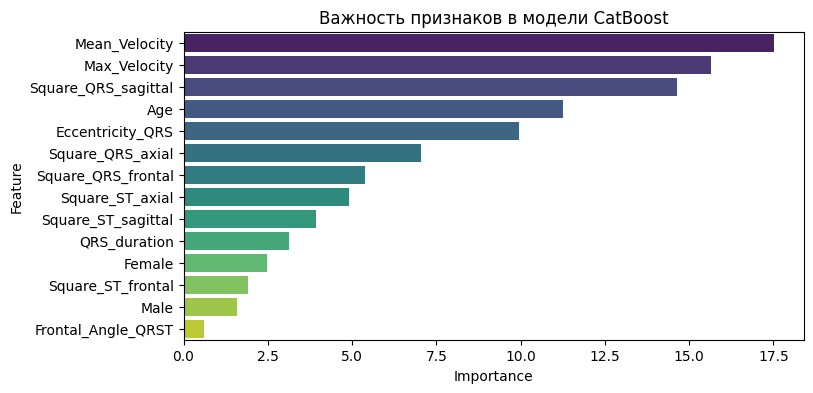

In [37]:

feature_importances = catboost_model.get_feature_importance()
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Важность признаков в модели CatBoost')
plt.show()
